<center><h1 style="font-size:40px;">Project 1<br> Recurrent Neural Networks
</h1></center>

---

This project will develop an **Recurrent neural network (RNN)**. The task is to predict the 5 next images in a series.

The task provide a dataset which creates a series of images where the last image in the series is the target. 

All **tasks** include **TODO's** thare are expected to be done before the deadline. The highlighted **Question's** should be answered in the report. Keep the answers separated so it is easy to read for the grading. Some sections include asserts or an expected result to give a and expected results are given. Some sections does not contain any **TODO's** but is good to understand them. 

For the **report** we have prepared an *Report.ipynb* notebook. The report should act as a summary of your findings and motivate your choice of approach. A better motivation show your understanding of the lab. Dont forget to include all **parts** in the report!

Good luck!

---

# Task

**TODO:** Implement **RNN** to predict the next image in the series. 

**TODO:** Select a good metric to evaluate the models performance and argue why the metric give a good overview of the performance.

**Question:** Explain in the report what you did and why. Present a pipeline of the code. 

--- 

**Note:** The current image resolution is set to 32x32 (i.e. IMAGE_WIDTH and IMAGE_HEIGHT) in config.py. 
This way initial experiements can run faster. Once you implement the inital version of the network, please set the resolution values back to 128x128. Experimental results should be provided for this high resolution images.  

**Hint:** As a generator model, you can use the segmentation model implemented in lab03. Do not forget to adapt the input and output shapes of the generator model in this case.




# Import packages

In [1]:
%load_ext autoreload
%autoreload 2
# Hacky solution to ac>cess the global utils package
import sys,os
sys.path.append(os.path.dirname(os.path.realpath('..')))

In [2]:
from config import LabConfig
import matplotlib.pyplot as plt
import torchmetrics
import transforms as T
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from utils.dataset import FutureFramePredictorDataset
from utils.plot import RNN
from utils.progressbar import LitProgressBar
from model import Model
import pytorch_lightning as pl
from pytorch_lightning.callbacks.progress import RichProgressBar
from rich.progress import track

## Load config
Note that this lab does not support for fineGrained dataset.

In [3]:
cfg = LabConfig()
cfg.todict()

{'training_img_dir': '../../data/FlyingObjectDataset_10K/training/image',
 'validation_img_dir': '../../data/FlyingObjectDataset_10K/validation/image',
 'testing_img_dir': '../../data/FlyingObjectDataset_10K/testing/image',
 'SEQUENCE_LENGTH': 7,
 'SEED': 420,
 'GPU': 0,
 'IMAGE_WIDTH': 128,
 'IMAGE_HEIGHT': 128,
 'IMAGE_CHANNEL': 3,
 'NUM_WORKERS': 4,
 'BATCH_SIZE': 32,
 'TENSORBORD_DIR': 'logs/'}

In [4]:
cfg.BATCH_SIZE = 15
cfg.SEQUENCE_LENGTH = 5
cfg.IMAGE_WIDTH = 32
cfg.IMAGE_HEIGHT = 32

# Dataset
First load the dataloaders for three datasets; train, validation and test. Feel free to test different augmentations, more can be found at [pytorch docs](https://pytorch.org/vision/stable/transforms.html)

The Artificial Flying Objects Dataset consist of a series of images where the last image in the series are the target image. All other images use the target image for the prediction. 

The dataset with images moving through a sequence.
- 128x128x3 
- Around 30 frames in each sequence, 
- In total 10K data for training, 2K for validation and 2K for testing

![Example Gif](../../data/images/ArtificialFlyingObjects.gif)


Note that ToTensor and Rezise are required to reshape and transform the images correct. We do not want to apply augmentation to the test_transform that are applied on the validation and test dataloader. For semantic segmentation we do not only have an input image $x$ but also an target label $y$. If we apply example: *RandomHorizontalFlip* the expected target image will be observed but will not be same rotation.

**Hint:** To ensure that the CNN take the images as a sequence the images are concatenated along the channel dimension. The input shape will look like: $(batch\_size*sequence\_length, C, H, W)$. Also, test: $x.view(batch\_size, sequence\_length, -1)$ to process the images in a sequence after CNN.

## Augmentation
To ensure that each image have the same shape we pad the dataset. It is possible to resize the images but then the bounding boxes also have to be transformed to correct shape which is not covered in this project! 

In [5]:
train_transform = T.Compose([
    T.ToTensor(),
    T.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),interpolation=torchvision.transforms.InterpolationMode.NEAREST),
    T.RandomHorizontalFlip(0.3)
])
test_transform = T.Compose([
    T.ToTensor(),
    T.Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH),interpolation=torchvision.transforms.InterpolationMode.NEAREST), #, 
])

## Dataloader

In [6]:
train_dataloader = DataLoader(
    FutureFramePredictorDataset(
        cfg.training_img_dir, 
        cfg.SEQUENCE_LENGTH,
        img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), 
        transforms=train_transform),
    batch_size=cfg.BATCH_SIZE,
    shuffle=True,
    num_workers=cfg.NUM_WORKERS
)

valid_dataloader = DataLoader(
    FutureFramePredictorDataset(
        cfg.validation_img_dir, 
        cfg.SEQUENCE_LENGTH,
        img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), 
        transforms=test_transform),
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS
)
test_dataloader = DataLoader(
    FutureFramePredictorDataset(
        cfg.testing_img_dir, 
        cfg.SEQUENCE_LENGTH,
        img_shape=(cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH), 
        transforms=test_transform),
    batch_size=cfg.BATCH_SIZE,
    shuffle=False,
    num_workers=cfg.NUM_WORKERS
)

print("Data batch generators are created!")

Data batch generators are created!


## Visualise data
To get an idea of the dataset we will first plot the data. This is very important, especially if we perform data augmentation. If the implementation is wrong an qualitative estimation will with a great probability tell if something is wrong.

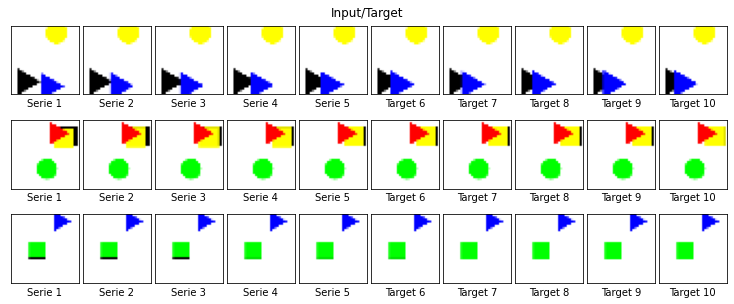

In [7]:
t_x, t_y = next(iter(train_dataloader))
RNN.data(t_x, t_y, cfg.SEQUENCE_LENGTH, nrows=3, title_size=2)

In [8]:
t_x.shape

torch.Size([15, 15, 32, 32])

In [9]:
t_y.shape

torch.Size([15, 15, 32, 32])

One drawback of the visualisation above is the "lack of change". Some images are difficult to define the change and therefore we can call RNN.diff to observe the difference from beginning to the end. The indicator is colored orange to symbolise the destination for each sequence image.

In [10]:
#RNN.diff(t_x, t_y, nrows=3, title_size=2, diff_color="orange")

# Implementation

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
print(device)

cuda:0


## ConvLSTM Cell

In [13]:
# ndrplz's ConvLSTM for pytorch
class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, frame_size):

        super(ConvLSTMCell, self).__init__()  

        self.activation = torch.tanh
        
        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)           

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.randn(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.randn(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.randn(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C

## Un-rolled ConvLSTM Cells

In [14]:
# Credit to Rohit Panda who expanded on ndrplz's convLSTM by packing the unrolled version into one module
# https://sladewinter.medium.com/video-frame-prediction-using-convlstm-network-in-pytorch-b5210a6ce582
class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, frame_size)

    def forward(self, X):
        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)
        # Technically (batch_size, num_channels*seq_len, height, width) 
        # but it's seperated to the former dimensions with view in Seq2Seq
        
        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, device=device)
        
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, 
        height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
        height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):
            # Send each time step into convLSTM cells
            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H
        return output

## Sequence-to-Sequence model

In [15]:
class Seq2Seq(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, frame_size):

        super(Seq2Seq, self).__init__()
        
        # Encoding ConvLSTM
        self.sequential1 = nn.Sequential()
        self.frame_size = frame_size
        
        # Add First layer (Different in_channels than the rest)
        self.convlstm1 = ConvLSTM(in_channels=num_channels, out_channels=num_kernels,
                                  kernel_size=kernel_size, padding=padding, frame_size=frame_size)
        
        #Future predictor 1
        self.convlstm2 = ConvLSTM(in_channels=num_kernels, out_channels=num_kernels,
                                  kernel_size=kernel_size, padding=padding, frame_size=frame_size)
        #Future predictor 2
        self.convlstm3 = ConvLSTM(in_channels=num_kernels, out_channels=num_kernels,
                                  kernel_size=kernel_size, padding=padding, frame_size=frame_size)
        #Future predictor 3
        self.convlstm4 = ConvLSTM(in_channels=num_kernels, out_channels=num_kernels,
                                  kernel_size=kernel_size, padding=padding, frame_size=frame_size)
        #Future predictor 4
        self.convlstm5 = ConvLSTM(in_channels=num_kernels, out_channels=num_kernels,
                                  kernel_size=kernel_size, padding=padding, frame_size=frame_size)
        #Future predictor 5
        self.convlstm6 = ConvLSTM(in_channels=num_kernels, out_channels=num_kernels,
                                  kernel_size=kernel_size, padding=padding, frame_size=frame_size)
        
        # Add Convolutional Layer to predict a output frame
        self.conv = nn.Conv2d(in_channels=num_kernels, out_channels=num_channels,
                              kernel_size=kernel_size, padding=padding)
        
        # 3D Convolutional Layer to predict the whole future sequence (making the previous redundant)
        self.conv3d = nn.Conv3d(in_channels=num_kernels, out_channels=num_channels,
                                kernel_size=3, padding=1)
    
    def forward(self, X):
        height, width = self.frame_size
        batch = X.size(0)
        # Change X to format (batch, channels, seq_len, height, width)
        X = X.view(batch, 3, 5, height, width).float()
        
        # Encodes first 5 frames
        output = self.convlstm1(X)
        
        # Predicts 1st future frame 
        output1 = self.convlstm2(output)
        
        # 2nd
        output2 = self.convlstm3(output1)
        
        # 3rd
        output3 = self.convlstm4(output2)
        
        # 4th
        output4 = self.convlstm5(output3)
        
        # 5th
        output5 = self.convlstm6(output4)
        
        future_frames = self.conv3d(output5) 
        
        # Changes dimensions into (batch, channels*seq_len, height, width)
        future_frames = future_frames.view(batch, -1, height, width)
        return nn.Sigmoid()(future_frames.double().to(device))

## Training

In [16]:
config = {
    'optimizer':{
        "type":torch.optim.Adam,
        "args":{
            "lr":2e-4,
            "weight_decay":2e-8
        }
    },
    'criterion':nn.MSELoss(), # error function
    'max_epochs':60,
    "train_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.SEQUENCE_LENGTH,compute_on_step=False),
        #torchmetrics.IoU(num_classes=cfg.SEQUENCE_LENGTH,compute_on_step=False)
    ],postfix="_Train"),
    "validation_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.SEQUENCE_LENGTH,compute_on_step=False),
        #torchmetrics.IoU(num_classes=cfg.SEQUENCE_LENGTH,compute_on_step=False)
    ],postfix="_Validation"),
    "test_metrics":torchmetrics.MetricCollection([
        torchmetrics.Accuracy(num_classes=cfg.SEQUENCE_LENGTH,compute_on_step=False),
        #torchmetrics.IoU(num_classes=cfg.SEQUENCE_LENGTH,compute_on_step=False)
    ],postfix="_Test")
}

In [17]:
torch.cuda.empty_cache()

In [18]:
print(torch.cuda.memory_summary(abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [19]:
load = False

In [20]:
if not load:    
    model = Model(Seq2Seq(num_channels=3, num_kernels=30, kernel_size=(3,3), padding=(1,1),
                          frame_size=(cfg.IMAGE_WIDTH, cfg.IMAGE_HEIGHT)), **config)

# Setup trainer
trainer = pl.Trainer(
            max_epochs=config['max_epochs'], 
            gpus=1,
            logger=pl.loggers.TensorBoardLogger(save_dir=cfg.TENSORBORD_DIR),
            callbacks=[RichProgressBar()],
            enable_model_summary='full', # Can be None, top or full
            num_sanity_val_steps=10,
            log_every_n_steps=2,
            precision=16
            )
if not load:
    # Train with the training and validation data- 
    trainer.fit(
        model, 
        train_dataloaders=train_dataloader,
        val_dataloaders=valid_dataloader
    );

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name               ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model              │ Seq2Seq          │  916 K │
│ 1 │ criterion          │ MSELoss          │      0 │
│ 2 │ train_metrics      │ MetricCollection │      0 │
│ 3 │ validation_metrics │ MetricCollection │      0 │
│ 4 │ test_metrics       │ MetricCollection │      0 │
└───┴────────────────────┴──────────────────┴────────┘

Trainable params: 916 K                                                                      
Non-trainable params: 0                                                                      
Total params: 916 K                                                                          
Total estimated model params size (MB): 1

Output()

## Save or Load model

In [21]:
if False:
    torch.save(model.state_dict(), './128x128_model_weight.pth')
if False:
    torch.save(model, './128x128_model.pth')
if False:
    model = torch.load('./128x128_model.pth')

In [22]:
if True:
    torch.save(model.state_dict(), './32x32_model_weight.pth')
if True:
    torch.save(model, './32x32_model.pth')
if False:
    model = torch.load('./32x32_model.pth')

In [23]:
trainer.test(model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

--------------------------------------------------------------------------------

DATALOADER:0 TEST RESULTS

{'loss_Test': 0.00754513218998909}

--------------------------------------------------------------------------------

[{'loss_Test': 0.00754513218998909}]

In [24]:
model.to(device)

Model(
  (model): Seq2Seq(
    (sequential1): Sequential()
    (convlstm1): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(33, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (convlstm2): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (convlstm3): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (convlstm4): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (convlstm5): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (convlstm6): ConvLSTM(
      (convLSTMcell): ConvLSTMCell(
        (conv): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1,

## Test results

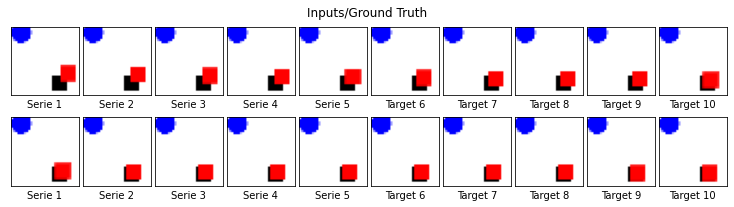

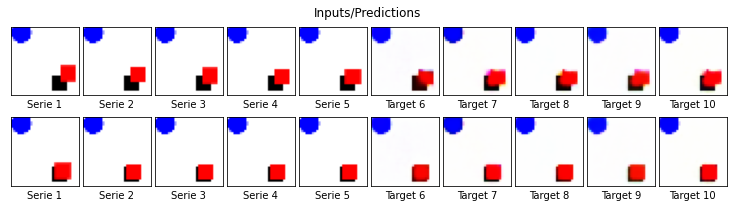

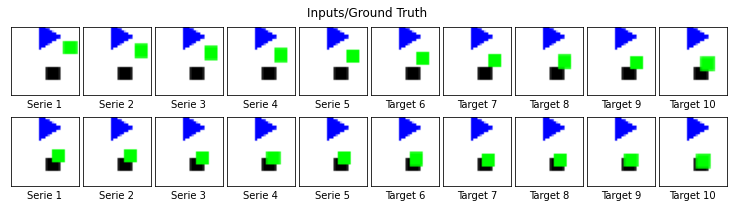

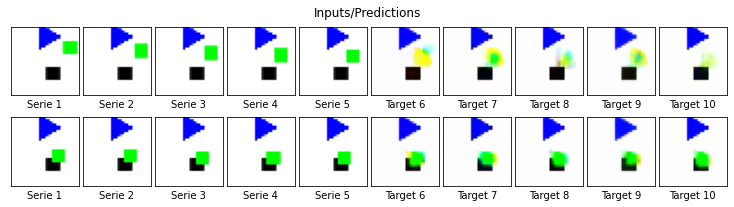

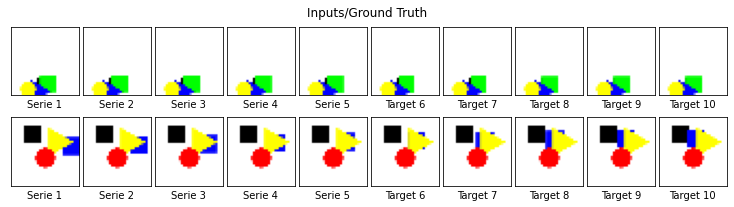

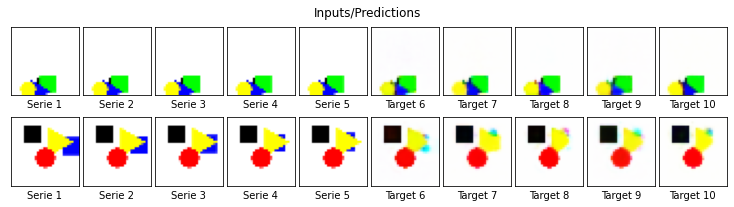

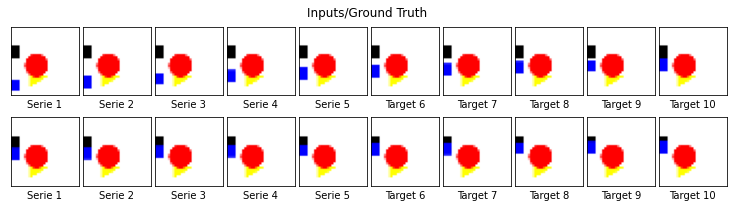

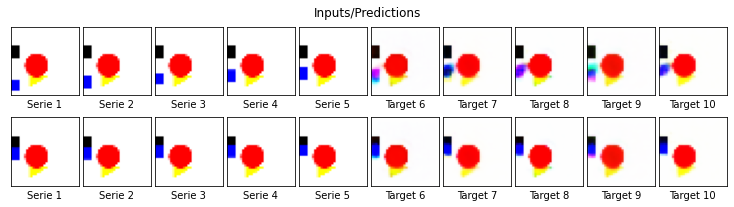

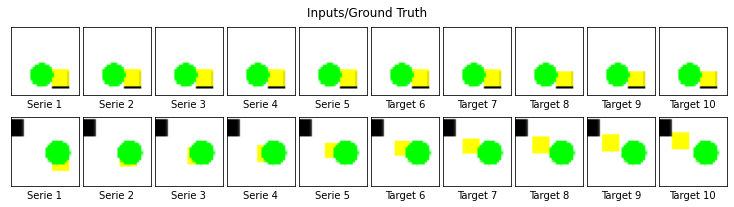

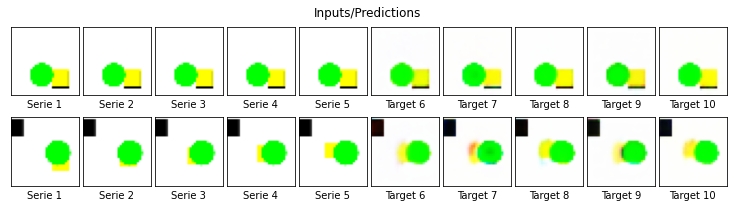

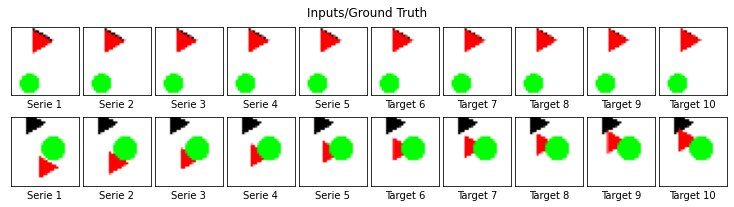

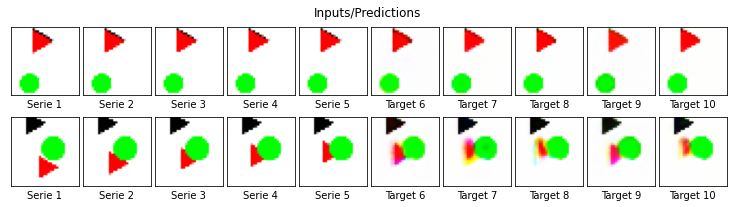

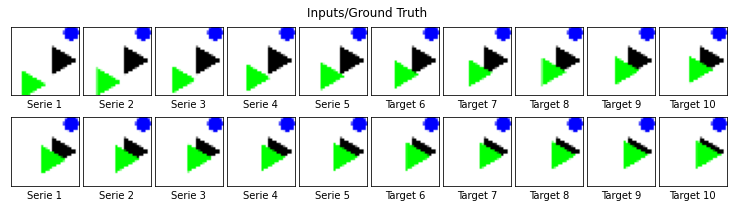

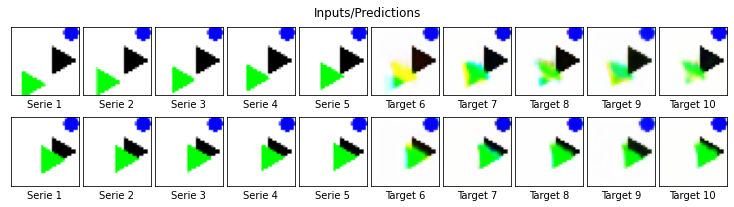

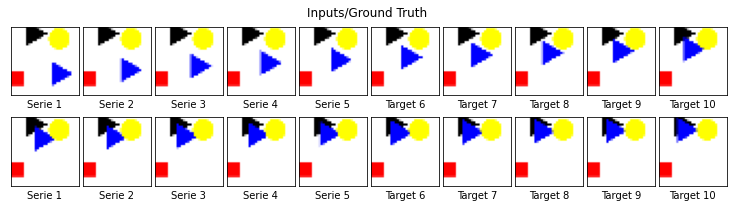

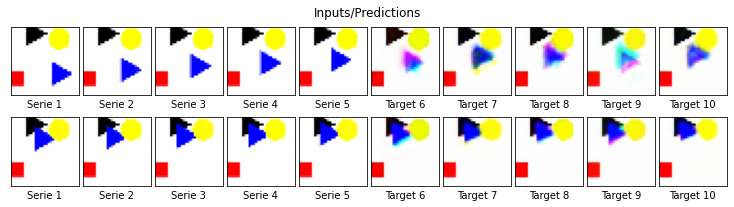

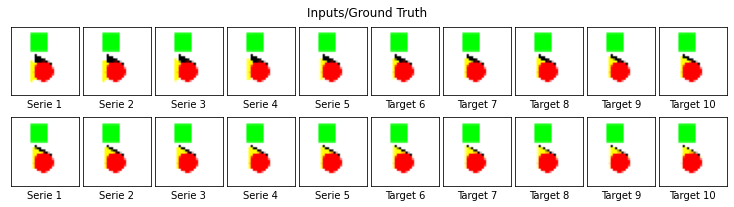

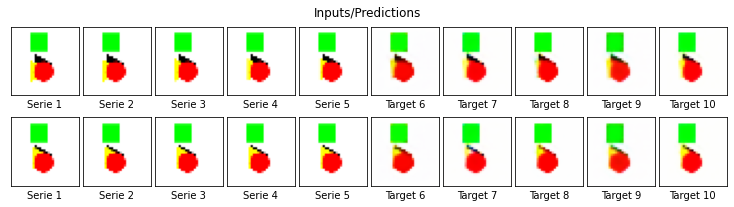

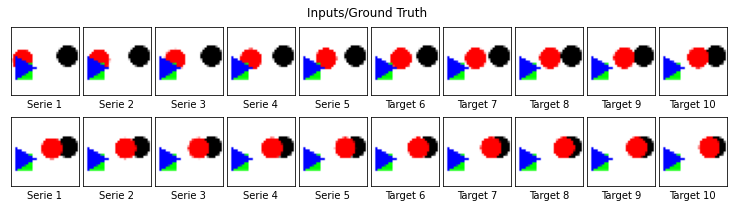

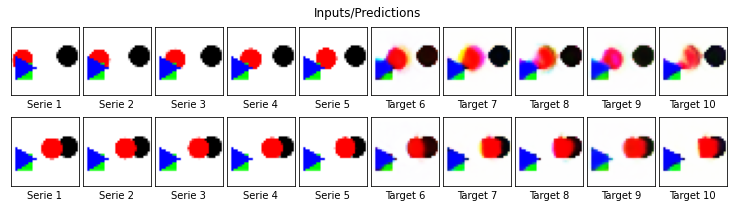

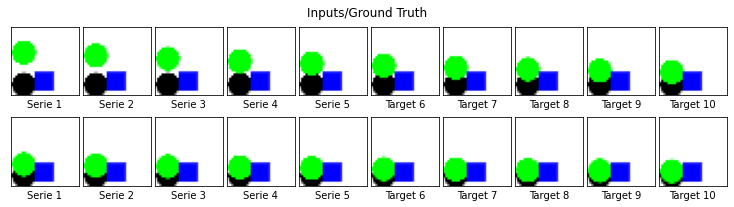

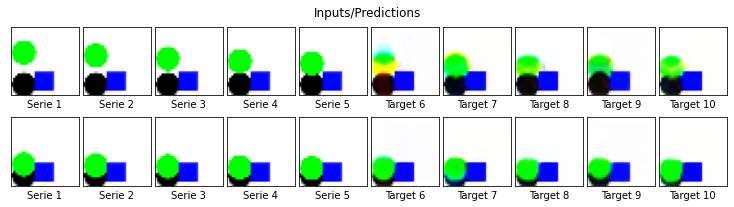

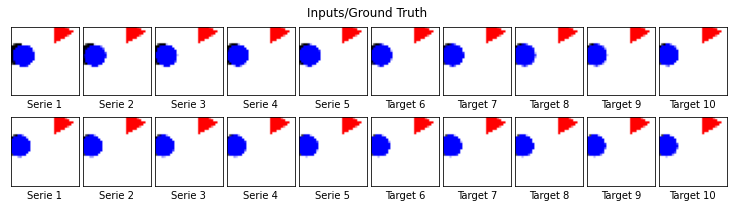

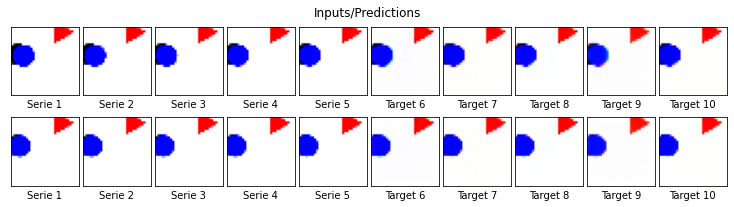

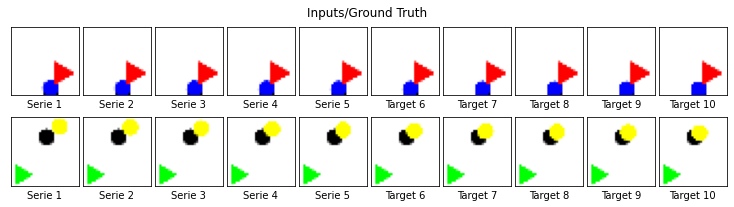

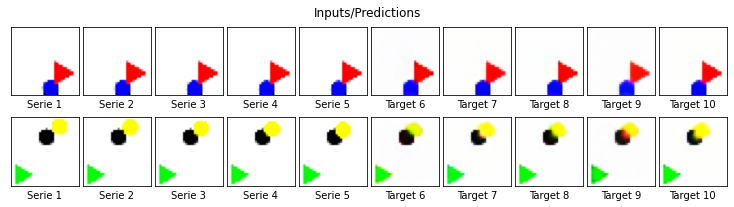

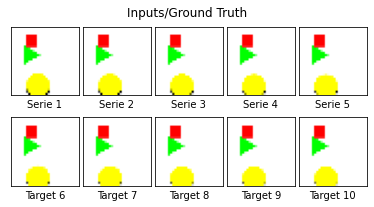

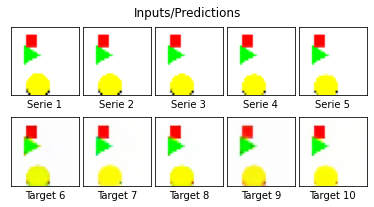

In [27]:
for x, y in iter(test_dataloader):
    x, y = x.to(device), y.to(device)
    preds = model(x)
    RNN.data(x.cpu(), y.cpu(), cfg.SEQUENCE_LENGTH, nrows=2, title="Inputs/Ground Truth")
    RNN.data(x.cpu(), preds.detach().cpu(), cfg.SEQUENCE_LENGTH, nrows=2, title="Inputs/Predictions")

In [30]:
!tar cvfz project.tar.gz *

128x128_model.pth
128x128_model_weight.pth
32x32_model.pth
32x32_model_weight.pth
config.py
logs/
logs/default/
logs/default/version_92/
logs/default/version_92/checkpoints/
logs/default/version_92/checkpoints/epoch=29-step=1439.ckpt
logs/default/version_92/events.out.tfevents.1644771007.liverpool.hh.se.2848387.7
logs/default/version_92/events.out.tfevents.1644770802.liverpool.hh.se.2848387.6
logs/default/version_92/hparams.yaml
logs/default/version_102/
logs/default/version_102/checkpoints/
logs/default/version_102/checkpoints/epoch=39-step=1919.ckpt
logs/default/version_102/events.out.tfevents.1644779366.liverpool.hh.se.2986005.1
logs/default/version_102/events.out.tfevents.1644778904.liverpool.hh.se.2986005.0
logs/default/version_102/hparams.yaml
logs/default/version_112_32x32/
logs/default/version_112_32x32/checkpoints/
logs/default/version_112_32x32/checkpoints/epoch=59-step=3839.ckpt
logs/default/version_112_32x32/events.out.tfevents.1644817968.liverpool.hh.se.3147548.0
logs/defa